In [82]:
# IMPORTS

import pandas as pd
import re

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
# LOAD DATA INTO TRAINING SET
training_set = pd.read_csv('train', delimiter=',',
                           header=None, names=['id', 'keyword', 'location', 'text', 'target'])

training_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
# FUNCTION TO CLEAN TEXT IN A TWEET

def clean(txt):
    # Remove special characters and convert to lowercase
    return re.sub('\W', ' ', txt).lower()


In [29]:
#DROP ANY COLUMNS THAT WE DON'T NEED
training_set.drop(['keyword', 'location'], axis=1, inplace=True)
training_set.head()


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [30]:
# CLEAN DATA

training_set.text = training_set.text.apply(clean)
training_set.to_csv('cleandata', index=False)

training_set.head()


,id,text,target
0,1,our deeds are the reason of this earthquake m...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are ...,1
3,6,13 000 people receive wildfires evacuation or...,1
4,7,just got sent this photo from ruby alaska as ...,1


In [33]:
# COUNT WORD OCCURRENCES IN FAKE AND REAL TWEETS

table = {
    0: {},
    1: {}
}

# For each row in training set
for row in training_set.itertuples():
    # Split tweet string into an array of words
    words = row.text.split()

    # For each word in tweet
    for word in words:
        # Add word to occurrence table if not exist
        # Default value is 1 to avoid "the 0 problem" (Laplace smoothing)
        if word not in table[0]:
            table[0][word] = 1
            table[1][word] = 1

        # Increment word occurrence by target
        table[row.target][word] += 1

table = pd.DataFrame(table)

table.head()


,0,1
deeds,2,2
reason,14,8
earthquake,6,46
may,39,51
allah,4,7


In [34]:
# CALCULATE CONSTANTS

# Probability that a tweet is fake or real disaster
p = training_set.target.value_counts(normalize=True).to_dict()

# Word count in fake and real tweets
n = table.sum().to_dict()

pd.DataFrame({
    'words': n,
    'probability': p
}).head()


,words,probability
0,67451,0.57034
1,62430,0.42966


In [35]:
# CALCULATE WORD OCCURRENCE PROBABILITY IN FAKE AND REAL TWEETS DISASTER

p_table = pd.DataFrame({
  0: table[0].apply(lambda x: x / n[0]),  
  1: table[1].apply(lambda x: x / n[1])
})

p_table.head()


,0,1
deeds,0.000030,0.000032
reason,0.000208,0.000128
earthquake,0.000089,0.000737
may,0.000578,0.000817
allah,0.000059,0.000112


In [36]:
# CLASSIFY A NEW TWEETS

def is_fake(txt):
    words = clean(txt).split()

    p_fake_given_message = p[0]
    p_real_given_message = p[1]

    for word in words:
        if word not in p_table[0]:
            continue
        p_fake_given_message *= p_table[0][word]
        p_real_given_message *= p_table[1][word]
    return p_fake_given_message > p_real_given_message

In [37]:
#APPLYING THE ALGORITHM TO PREDICT FOR THE TRAINING_SET
results = []
for index, row in training_set.iterrows():
    result = is_fake(row['text'])
    predict = 0 if result else 1
    results.append(predict)
training_set['predict'] = results
training_set.head(50)


,id,text,target,predict
0,1,deeds reason earthquake may allah forgive us,1,1
1,4,forest fire near la ronge sask canada,1,1
2,5,residents asked shelter place notified officer...,1,1
3,6,13 000 people receive wildfires evacuation ord...,1,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1,1
5,8,rockyfire update california hwy 20 closed dire...,1,1
6,10,flood disaster heavy rain causes flash floodin...,1,1
7,13,top hill see fire woods,1,1
8,14,emergency evacuation happening building across...,1,1
9,15,afraid tornado coming area,1,1


In [38]:
#ACCURATING FOR THE ALGORITHM
ground_truth = training_set["target"].values
predictions = training_set["predict"].values

accuracy = accuracy_score(ground_truth, predictions)
accuracy


0.918429003021148

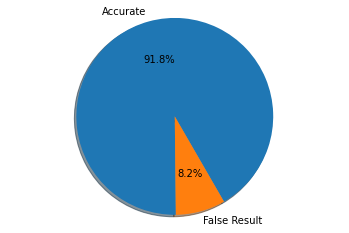

In [39]:
labels = ['Accurate', 'False Result']
sizes = [accuracy, 1 - accuracy]  
# Plot
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', shadow=True, startangle=-60)
plt.axis('equal')
plt.show()

In [31]:
#FUNCTION TO REMOVE STOP WORDS IN TWEETS
def removeSW(txt):
    text_tokens = word_tokenize(txt)

    token_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
    return (" ").join(token_without_sw)


In [32]:
# REMOVE STOP WORD IN TRAINING_SET

training_set.text = training_set.text.apply(removeSW)

training_set.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,13 000 people receive wildfires evacuation ord...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1
